In [2]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [3]:
output_path = 'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis256_LL0.05'
output_path_long = output_path + '_very_long'
save_path = 'data\\nematic_analysis256_LL0.05'

if not os.path.exists(save_path):
    os.makedirs(save_path)
path0 = os.path.join(output_path, 'analysis_zeta_0.022\\zeta_0.022_counter_0')
path0_long = os.path.join(output_path_long, 'analysis_zeta_0.020\\zeta_0.020_counter_0')
sys.path.append(output_path)

Nexp = 10
Nexp_long = 20
Nframes = 181
Nframes = len(np.loadtxt(os.path.join(path0, 'Ndefects_act0.022_exp0.txt')))
Nframes_long = len(np.loadtxt(os.path.join(path0_long, 'Ndefects_act0.02_exp0.txt')))
LX = 256

act_list = []
act_dir_list = []
act_list_long = []
act_dir_list_long = []

for file in os.listdir(output_path):
        activity = file.split('_')[-1]
        act_list.append(float(activity))
        act_dir_list.append(os.path.join(output_path, file))
for file in os.listdir(output_path_long):
        activity = file.split('_')[-1]
        act_list_long.append(float(activity))
        act_dir_list_long.append(os.path.join(output_path_long, file))

# sort the activity list and the activity directory list
act_list, act_dir_list = zip(*sorted(zip(act_list, act_dir_list)))
act_list_long, act_dir_list_long = zip(*sorted(zip(act_list_long, act_dir_list_long)))

Nactivity = len(act_list)
Nactivity_long = len(act_list_long)
conv_list = Nactivity * [0]

# save act list
np.savetxt(os.path.join(save_path, 'act_list.txt'), act_list)

Nexp, Nexp_long, Nframes, Nframes_long, Nactivity


(10, 20, 181, 1501, 34)

In [4]:

conv_dict = dict(zip(act_list, conv_list))

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.nan * np.zeros((Nframes, Nactivity, Nexp))
av_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
var_counts = np.nan * np.zeros([Nframes, len(window_sizes), Nactivity, Nexp])
count_lengths = np.zeros([Nactivity, Nexp])

for i, act in enumerate(act_list):
    
    exp_list = []
    exp_dir_list = []

    for file in os.listdir(act_dir_list[i]):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir_list[i], file))

    # sort the activity list and the activity directory list
    exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

    for exp, exp_dir in zip(exp_list, exp_dir_list):
        defect_arr[:, i, exp] = np.loadtxt(os.path.join(exp_dir, 'Ndefects_act{}_exp{}.txt'.format(act, exp)))[:Nframes]


        counts = np.loadtxt(os.path.join(exp_dir, 'av_counts_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]
        vars = np.loadtxt(os.path.join(exp_dir, 'count_fluctuations_act{}_exp{}.txt'.format(act,exp)))[:Nframes,:]

        idx_start_count = min(Nframes - conv_list[i], len(counts))
        av_counts[-idx_start_count:, :, i, exp] = counts[-idx_start_count:, :]
        var_counts[-idx_start_count:, :, i, exp] = vars[-idx_start_count:, :]
        count_lengths[i, exp] = idx_start_count

dens_fluc = var_counts / (np.pi * window_sizes[:, None, None] ** 2) ** 2





In [6]:
exp_conv_list= np.ones((Nexp, Nactivity)).astype(float)

In [8]:
# load arrays
normalize = True
save = False
act_to_remove = []

act_very_long_lower = 0.0195
act_very_long_upper = 0.0235
act_long_upper = 0.024
act_idx_very_long = act_list.index(act_very_long_upper)
act_idx_very_long_lower = act_list.index(act_very_long_lower)   
act_idx_long = act_list.index(act_long_upper)
idx_exp_to_keep_list = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
idx_act_to_keep_list = np.where(~np.isin(act_list, act_to_remove))[0]
conv_list = np.delete(conv_list, np.where(np.isin(act_list, act_to_remove))[0])
                 
conv_dict = dict(zip(act_list, conv_list))
act_list = list(np.delete(act_list, np.where(np.isin(act_list, act_to_remove))[0]))
Nactivity = len(act_list)
Nexp = len(idx_exp_to_keep_list)

window_sizes = np.loadtxt(os.path.join(path0, 'window_sizes.txt'))

defect_arr = np.load(os.path.join(save_path, 'defect_arr.npy'))[:, :, idx_exp_to_keep_list][:, idx_act_to_keep_list, :] / LX ** 2

av_defects = np.zeros((Nactivity, 2)) 
defect_arr_av = np.mean(defect_arr, axis=2)
defect_arr_std = np.std(defect_arr, axis=2)

for i, act in enumerate(act_list):
    av_defects[i, 0] = np.mean(defect_arr_av[conv_dict[act]:, i])
    av_defects[i, 1] = np.mean(defect_arr_std[conv_dict[act]:, i]) / np.sqrt(Nframes - conv_dict[act])
av_defects[act_idx_very_long_lower:act_idx_very_long, 0] = np.loadtxt(os.path.join(save_path, 'av_defects_very_long.txt'))[:, 0]
av_defects[act_idx_very_long_lower:act_idx_very_long, 1] = np.loadtxt(os.path.join(save_path, 'av_defects_very_long.txt'))[:, 1]
av_defects[act_idx_long-2:act_idx_long, 0] = np.loadtxt(os.path.join(save_path, 'av_defects_long.txt'))[-2:, 0]
av_defects[act_idx_long-2:act_idx_long, 1] = np.loadtxt(os.path.join(save_path, 'av_defects_long.txt'))[-2:, 1]

av_counts = np.load(os.path.join(save_path, 'av_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
av_counts = av_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
av_counts_av = np.nanmean(av_counts, axis=3)
av_counts_std = np.nanstd(av_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

var_counts = np.load(os.path.join(save_path, 'var_counts.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
var_counts = var_counts * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
var_counts_av = np.nanmean(var_counts, axis=3)
var_counts_std = np.nanstd(var_counts, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

dens_fluc = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc = dens_fluc * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]
dens_fluc_av = np.nanmean(dens_fluc, axis=3)
dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if normalize:
    dens_fluc = dens_fluc / defect_arr[:, None, :, :] ** 2
    dens_fluc_av = np.nanmean(dens_fluc, axis=3)
    dens_fluc_std = np.nanstd(dens_fluc, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if save:
    np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
    np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
    np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
    np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
    np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
    np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
    np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)
 

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9708\2658872126.py:44: RuntimeWarning: Mean of empty slice
  var_counts_av = np.nanmean(var_counts, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9708\2658872126.py:49: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_9708\2658872126.py:54: RuntimeWarning: Mean of empty slice
  dens_fluc_av = np.nanmean(dens_fluc, axis=3)


In [13]:
av_defects[act_idx_very_long_lower:act_idx_very_long, 0] = np.loadtxt(os.path.join(save_path, 'av_defects_very_long.txt'))[:, 0]   / LX **2
av_defects[act_idx_very_long_lower:act_idx_very_long, 1] = np.loadtxt(os.path.join(save_path, 'av_defects_very_long.txt'))[:, 1]  / LX **2
av_defects[act_idx_long-2:act_idx_long, 0] = np.loadtxt(os.path.join(save_path, 'av_defects_long.txt'))[-2:, 0] / LX **2
av_defects[act_idx_long-2:act_idx_long, 1] = np.loadtxt(os.path.join(save_path, 'av_defects_long.txt'))[-2:, 1] / LX **2

var_counts_av[-Nframes:, :, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'var_counts_long_av_very_long.npy'))[-Nframes:, :, :]
var_counts_std[-Nframes:, :, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'var_counts_long_std_very_long.npy'))[-Nframes:, :, :]
var_counts_av[-Nframes:, :, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'var_counts_long_av_long.npy'))[-Nframes:, :, -2:]
var_counts_std[-Nframes:, :, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'var_counts_long_std_long.npy'))[-Nframes:, :, -2:]

dens_fluc_av[-Nframes:, :, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'dens_fluc_full_av_very_long.npy'))[-Nframes:, :, :]
dens_fluc_std[-Nframes:, :, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'dens_fluc_full_std_very_long.npy'))[-Nframes:, :, :]
dens_fluc_av[-Nframes:, :, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'dens_fluc_full_av_long.npy'))[-Nframes:, :, -2:]
dens_fluc_std[-Nframes:, :, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'dens_fluc_full_std_long.npy'))[-Nframes:, :, -2:]

defect_arr_av[-Nframes:, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'defect_arr_av_very_long.npy'))[-Nframes:, :]  / LX **2
defect_arr_std[-Nframes:, act_idx_very_long_lower:act_idx_very_long] = np.load(os.path.join(save_path, 'defect_arr_std_very_long.npy'))[-Nframes:, :]  / LX **2
defect_arr_av[-Nframes:, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'defect_arr_av_long.npy'))[-Nframes:, -2:]  / LX **2
defect_arr_std[-Nframes:, act_idx_long-2:act_idx_long] = np.load(os.path.join(save_path, 'defect_arr_std_long.npy'))[-Nframes:, -2:]  / LX **2

if save:
    np.save(os.path.join(save_path, 'av_counts_av.npy'), av_counts_av)
    np.save(os.path.join(save_path, 'av_counts_std.npy'), av_counts_std)
    np.save(os.path.join(save_path, 'var_counts_av.npy'), var_counts_av)
    np.save(os.path.join(save_path, 'var_counts_std.npy'), var_counts_std)
    np.save(os.path.join(save_path, 'dens_fluc_av.npy'), dens_fluc_av)
    np.save(os.path.join(save_path, 'dens_fluc_std.npy'), dens_fluc_std)
    np.save(os.path.join(save_path, 'av_defects.npy'), av_defects)

In [12]:
min_window_idx=6
first_frame_list = np.array(conv_list)
Nframes_non_nan_counts = Nframes - np.array(first_frame_list)

min_act_idx = 2
conv_dict[0.024] = 0

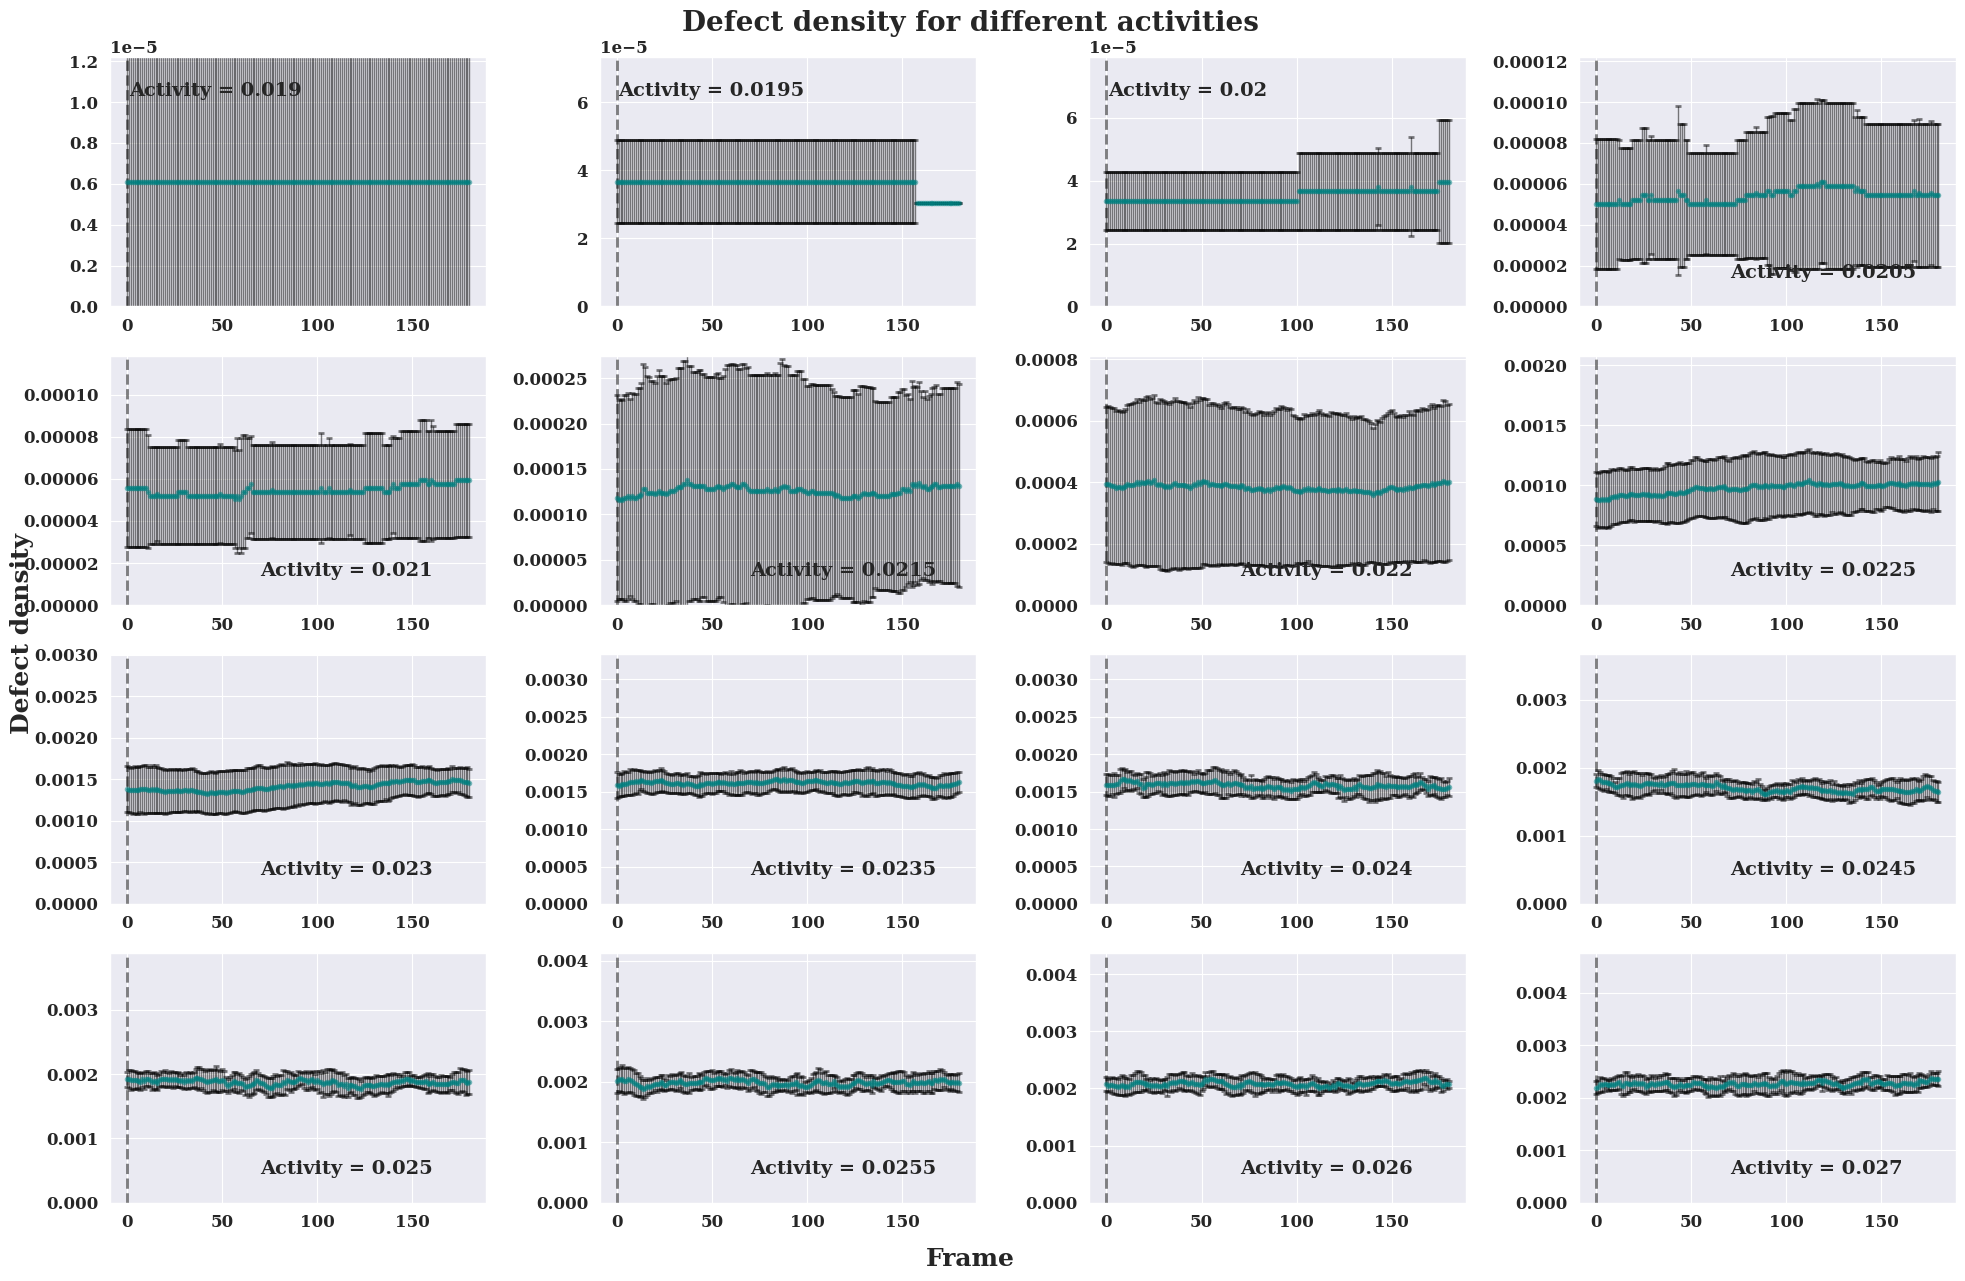

In [18]:
ncols = 4
nrows = int(np.ceil(Nactivity / ncols))
nrows = 4
fig, ax = plt.subplots(nrows = nrows, ncols = 4, figsize=(20, 13))
ax = ax.flatten()
for i, act in enumerate(act_list[min_act_idx:min_act_idx + 16]):
    act_idx = act_list.index(act)
    ax[i].errorbar(np.arange(Nframes), defect_arr_av[:, act_idx], defect_arr_std[:, act_idx], label='activity = {}'.format(act), fmt='.', \
                   capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='black')
    
    # plot vertical lines to indicate the start of the averaging
    ax[i].axvline(x=conv_dict[act], color='black', linestyle='--', alpha=0.5)
    ax[i].set_ylim(0 , np.max(defect_arr_av[:, act_idx]) * 2 )


    if i < 3:
        ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
    else:
        ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

fig.suptitle('Defect density for different activities')
fig.supxlabel('Frame')
fig.supylabel('Defect density')

#ax[-1].axis('off')
#ax[-2].axis('off')


plt.tight_layout()
plt.show()

In [36]:
def linear(x, a, b):
    return a * x + b
# Try fitting with other functions
def qudratic(x, a, b, c):
    return a * x**2 + b * x + c
def power(x, a, b, c, d):
    return a * x**d + b * x + c
def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c

In [37]:
# do a linear fit to the average defect density
param_guess_lin = np.array([70 * 100, 100])
param_guess_quad = np.array([70 * 100, 100, 0])
param_guess_power = np.array([7000, 2, 7100, -29])
param_guess_log = np.array([7000, 300, 30])
fit_func = log_func
fit_string = rf'$y = a x^2 + bx + c$'
fit_string = rf'$y = a \ln x + bx + c $'

param_guess = param_guess_log / LX ** 2
# fit starting with different lower activity values
for i in range(0, len(act_list) - 1):
    lin_fit = do_chi2_fit(fit_func, act_list[i:], av_defects[i:, 0], av_defects[i:, 1], parameter_guesses= param_guess, verbose=False)

    print("Fitting only activities >= {}".format(act_list[i]))
    Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[i:]))
    print("Ndof, chi2, pval: ", Ndof, np.round(chi2, 2), np.round(pval, 7))
print("\n\n")

 
lower_act_index = act_list.index(0.0235)

lin_fit = do_chi2_fit(fit_func, act_list[lower_act_index:], av_defects[lower_act_index:, 0], av_defects[lower_act_index:, 1], parameter_guesses= param_guess, verbose=False)
Ndof, chi2, pval = get_statistics_from_fit(lin_fit, len(act_list[lower_act_index:]))


C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of ``func_code`` attribute to declare parameters is deprecated. Use ``_parameters`` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])


Fitting only activities >= 0.016
Ndof, chi2, pval:  31 nan nan
Fitting only activities >= 0.018
Ndof, chi2, pval:  30 nan nan
Fitting only activities >= 0.019
Ndof, chi2, pval:  29 nan nan
Fitting only activities >= 0.0195
Ndof, chi2, pval:  28 nan nan
Fitting only activities >= 0.02
Ndof, chi2, pval:  27 nan nan
Fitting only activities >= 0.0205
Ndof, chi2, pval:  26 nan nan
Fitting only activities >= 0.021
Ndof, chi2, pval:  25 nan nan
Fitting only activities >= 0.0215
Ndof, chi2, pval:  24 nan nan
Fitting only activities >= 0.022
Ndof, chi2, pval:  23 nan nan
Fitting only activities >= 0.0225
Ndof, chi2, pval:  22 nan nan
Fitting only activities >= 0.023
Ndof, chi2, pval:  21 nan nan
Fitting only activities >= 0.0235
Ndof, chi2, pval:  20 nan nan
Fitting only activities >= 0.024
Ndof, chi2, pval:  19 nan nan
Fitting only activities >= 0.0245
Ndof, chi2, pval:  18 nan nan
Fitting only activities >= 0.025
Ndof, chi2, pval:  17 nan nan
Fitting only activities >= 0.0255
Ndof, chi2, pval

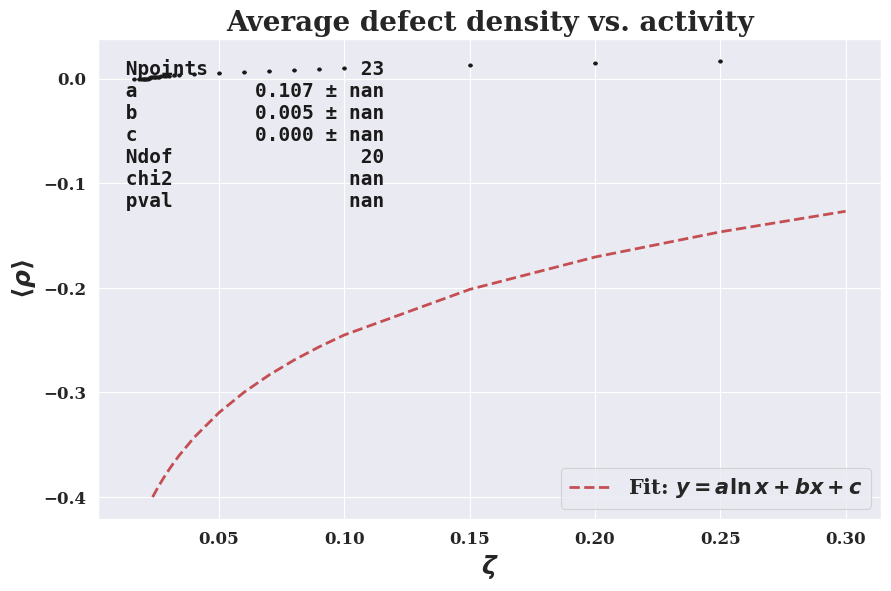

In [38]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.errorbar(act_list, av_defects[:, 0], yerr = av_defects[:, 1], fmt = 'k.', elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)
ax.set_xlabel(r'$\zeta$')
ax.set_ylabel(r'$\langle \rho \rangle$')
ax.set_title('Average defect density vs. activity')

ax.plot(act_list[lower_act_index:], fit_func(np.array(act_list[lower_act_index:]), *lin_fit.values[:]), 'r--', label=rf'Fit: {fit_string}')

d = {'Fit1: y = a1x + b1': '', 'a1': [lin_fit.values['a'], lin_fit.errors['a']], 'b1': [lin_fit.values['b'],lin_fit.errors['b'] ],\
      'Fit1 Ndof1': Ndof, 'chi2val1': chi2, 'pval1': pval}

d = generate_dictionary(lin_fit, len(act_list[lower_act_index:]), chi2_suffix = None)

#d.update(d_lower)
text = nice_string_output(d, extra_spacing=4, decimals=3)
add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)
ax.legend(loc='lower right')

fig.tight_layout()
plt.show()

In [39]:
def lin_func(x, alpha, beta):
    return beta * (2 - alpha) + (2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin = np.array([0.1, 0.3])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func
param_guess = param_guess_lin
log_fit = True
fit_string = rf'$y = \beta(2-\alpha) + (2-\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params = np.zeros([Nframes, len(act_list), 2 * Nparams]) * np.nan
stat_arr = np.zeros([Nframes, len(act_list), 3]) * np.nan

In [84]:
act_list[min_act_idx]

0.0195

In [40]:
for i,act in enumerate(act_list):
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
    if np.isnan(count_var_av).sum() > 0:
            continue
    zero_mask = count_var_av > 0
    count_var_av = count_var_av[zero_mask]
    count_var_std = count_var_std[zero_mask]
    
    if 0 < len(count_var_av) < 30:
        print("Fitting for activity {} and frame {}".format(act, frame))
        print(len(count_var_av))
        print(count_var_av)

Fitting for activity 0.0215 and frame 180
24
[0.01162 0.01162 0.01162 0.01162 0.01162 0.01162 0.01162 0.01162 0.01162
 0.01162 0.01162 0.01162 0.01162 0.03341 0.07625 0.12214 0.12214 0.12214
 0.16855 0.16855 0.16274 0.16611 0.24043 0.24478]
Fitting for activity 0.022 and frame 180
24
[0.03483 0.03483 0.03782 0.05707 0.07896 0.07896 0.10142 0.10871 0.11213
 0.12522 0.13547 0.14998 0.17749 0.1915  0.21111 0.24001 0.28462 0.3516
 0.48816 0.58503 0.74129 0.96686 1.03868 1.2054 ]
Fitting for activity 0.0225 and frame 180
24
[0.04421 0.05771 0.07299 0.07824 0.08351 0.09107 0.10488 0.11587 0.14156
 0.17251 0.19704 0.21726 0.29464 0.32773 0.38813 0.48151 0.56123 0.65263
 0.76095 0.84018 1.03327 1.26959 1.66789 2.07374]
Fitting for activity 0.023 and frame 180
24
[0.02366 0.02366 0.02862 0.03636 0.03636 0.04702 0.06982 0.07539 0.10722
 0.12519 0.14591 0.18787 0.21046 0.25146 0.31915 0.38828 0.45758 0.55847
 0.70025 0.85835 1.1232  1.38575 1.82795 2.26506]
Fitting for activity 0.0235 and frame 1

In [41]:
for i, act in enumerate(act_list):  
    if act < act_list[min_act_idx]:
        continue
    for frame in np.arange(first_frame_list[i], Nframes):
        count_var_av = var_counts_av[frame, min_window_idx:, i]
        count_var_std = var_counts_std[frame, min_window_idx:, i]
        if np.isnan(count_var_av).sum() > 0 or np.isnan(count_var_std).sum() > 0:
            continue

        zero_mask = count_var_av > 0
        if len(count_var_av[zero_mask]) < 10:
            continue

        if log_fit:
            try:
              #  with warnings.catch_warnings():
               #     warnings.simplefilter("ignore", category=np.runtimewarning)
                x = np.log(R[zero_mask])
                y = np.log(count_var_av[zero_mask])
                yerr = count_var_std[zero_mask] / count_var_av[zero_mask]
            except:
                print("Error in log for activity = ", act)
                continue
        else:
            x = R[zero_mask]
            y = count_var_av[zero_mask]
            yerr = count_var_std[zero_mask]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            fit = do_chi2_fit(fit_func, x, y, yerr, param_guess, verbose = False)

        Ndof, chi2, prop = get_statistics_from_fit(fit, len(R[zero_mask]), subtract_1dof_for_binning = False)
 
        fit_params[frame, i, :Nparams] = fit.values[:]
        fit_params[frame, i, Nparams:] = fit.errors[:]
        stat_arr[frame, i, :] = Ndof, chi2, prop

print("Non-converged fits: ", np.nansum((stat_arr[:, :, -1] < 0.05)))

# save
np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}.npy'), fit_params)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}.npy'), stat_arr)

C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)
C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)
C:\Users\Simon Andersen\Projects\Projects\Appstat2022\External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)


Non-converged fits:  18


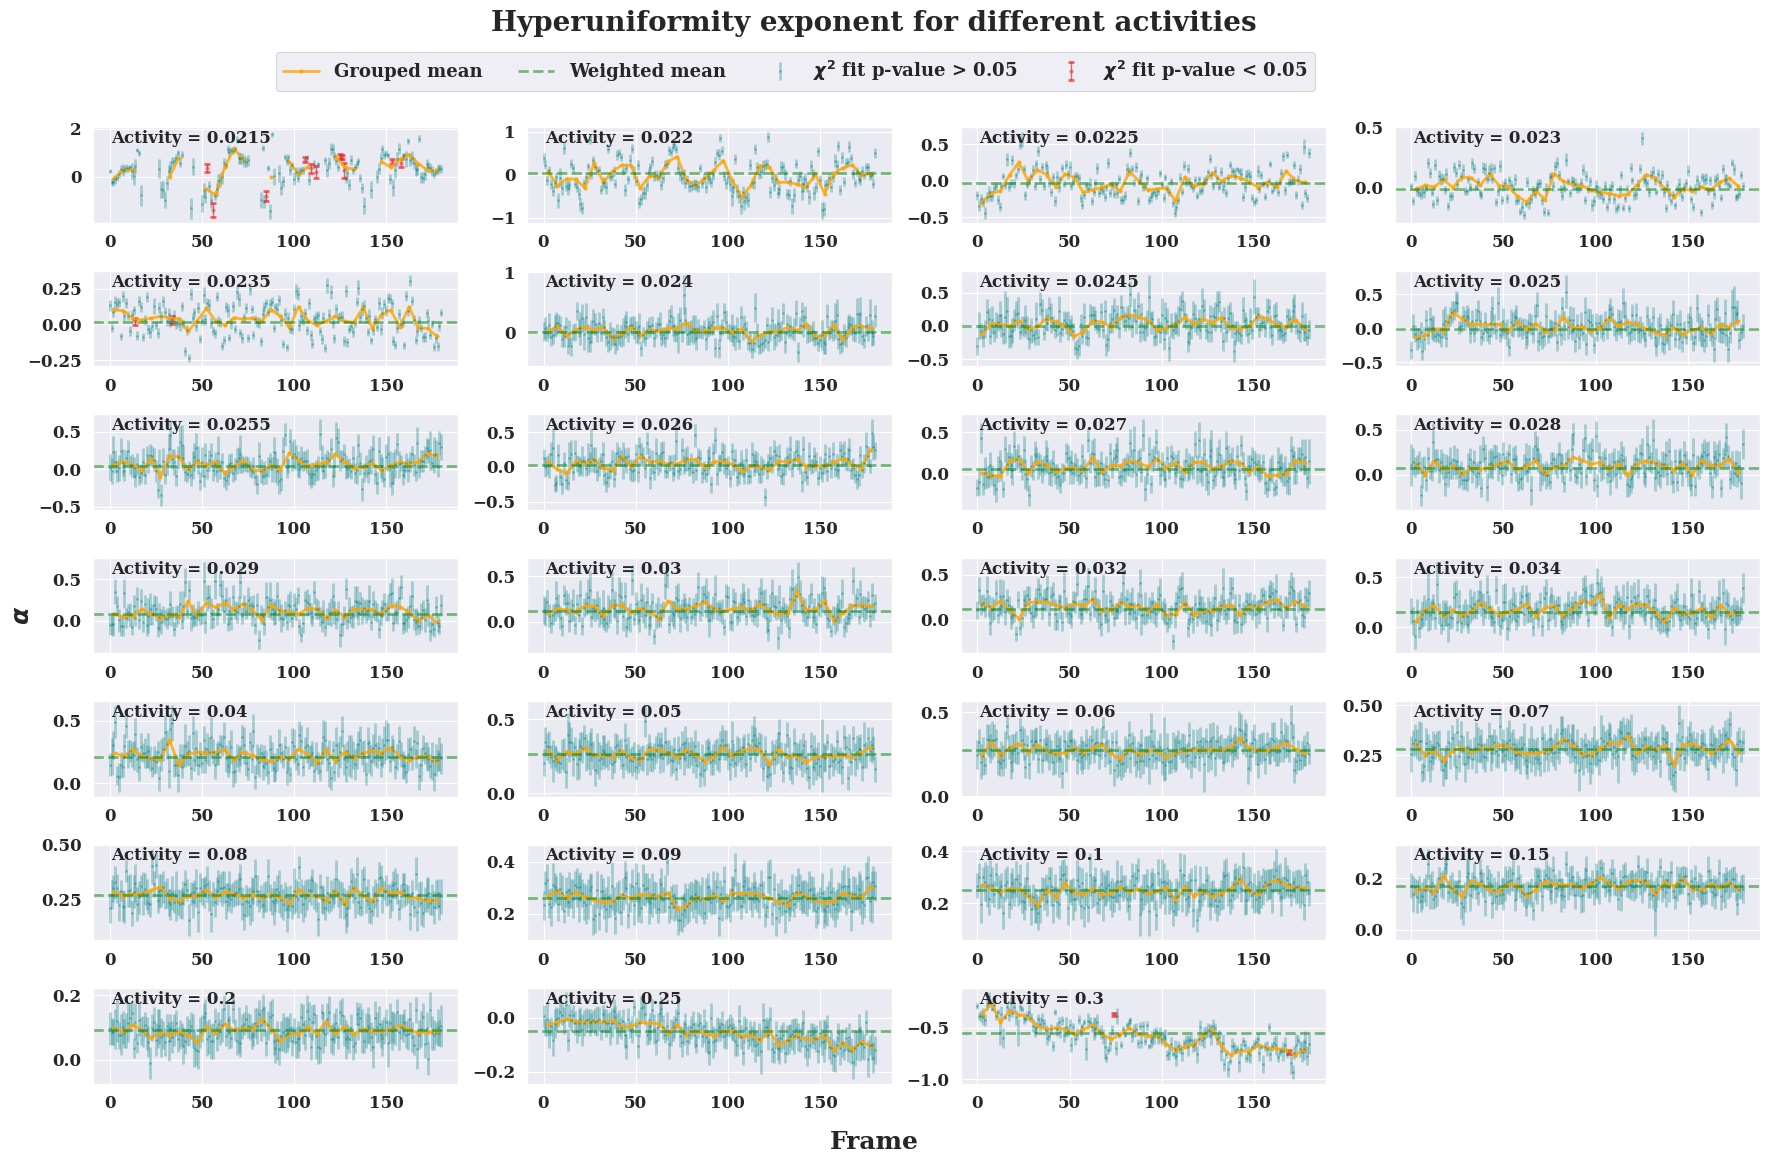

In [42]:
fig, ax = plt.subplots(nrows = 7, ncols = 4, figsize=(18, 11))

ax = ax.flatten()
Ngroup = 5

for i, act in enumerate(act_list[min_act_idx+1:min_act_idx+1+28]):
    act_idx = act_list.index(act)
    
    if i == 0:
        label1 = rf'$\chi^2$ fit p-value > 0.05'
        label2 = rf'$\chi^2$ fit p-value < 0.05'
        label3 = 'Weighted mean'
        label4 = 'Grouped mean'
    else:
        label1 = None
        label2 = None
        label3 = None
        label4 = None

    p_mask = stat_arr[first_frame_list[act_idx]:, act_idx, 2] > 0.05

    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[p_mask], \
                   fit_params[first_frame_list[act_idx]:,act_idx,0][p_mask], \
                    fit_params[first_frame_list[act_idx]:,act_idx,Nparams][p_mask], \
                       fmt='.', \
                   alpha = 0.3, markersize=2, label = label1)# ecolor='black')capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, 
    
    ax[i].errorbar(np.arange(first_frame_list[act_idx], Nframes)[~p_mask], \
                     fit_params[first_frame_list[act_idx]:,act_idx,0][~p_mask], \
                      fit_params[first_frame_list[act_idx]:,act_idx,Nparams][~p_mask], \
                        fmt='r.', \
                     capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.6, markersize=2, ecolor='red', label = label2)

    x = fit_params[first_frame_list[act_idx]:, act_idx, 0]

    max_idx = len(x) - len(x) % Ngroup 
    # group the data and calculate the weighted mean and error on mean
    x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
    dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)
    x_frames = np.arange(first_frame_list[act_idx], first_frame_list[act_idx] + max_idx, Ngroup) + Ngroup / 2

    # plot x_group and dx_group
    ax[i].plot(x_frames, x_group, '.-', color='orange', alpha=0.8, markersize=4, label = label4)
    if 0:
        ax[i].errorbar(x_frames, \
                    x_group, \
                        dx_group, \
                        fmt='.', \
                    alpha = 0.5, markersize=4, ecolor='orange')


    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
    #ax[i].axhline(mean, color='orange', linestyle='-', alpha=0.5, lw = 2, label = label3)
    

    # calc and plot weighted mean and error on mean for all frames and activities
    mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, fit_params[first_frame_list[i]:, act_idx, Nparams])
    ax[i].axhline(mean, color='green', linestyle='--', alpha=0.5, lw = 2, label = label3)
    
    # plot vertical lines to indicate the start of the averaging
  #  ax[i].axhline(0, color='black', linestyle='--', alpha=0.5)
    #ax[i].set_ylim(np.min(defect_arr_av[:,i])/2, np.max(defect_arr_av[:, i]) + 2  * np.max(defect_arr_std[:, i]))
    ax[i].text(0.05, 0.97, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=12, verticalalignment='top')
    if 0:
        if i < 3:
            ax[i].text(0.05, 0.9, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='top')
        else:
            ax[i].text(0.4, 0.1, 'Activity = {}'.format(act), transform=ax[i].transAxes, fontsize=14, verticalalignment='bottom')

#ax[-2].axis('off')
ax[-1].axis('off')

fig.suptitle('Hyperuniformity exponent for different activities', y=1.05)
fig.supxlabel('Frame')
fig.supylabel(rf'$\alpha$')
fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.75, 1.02))

plt.tight_layout()
plt.show()

In [43]:
def lin_func_dens(x, alpha, beta):
    return beta * (- 2 - alpha) + (- 2 - alpha) * x
def power_func(x, b): #, c, d, e):
    return  b * x ** 2
def power_log_func(x, b): #, c, d, e):
    return  b * x ** 2 * np.log(x)

param_guess_lin_dens = np.array([0.1, 0.1])
param_guess_power = np.array([2400])
param_guess_power_log = np.array([2000])

R = window_sizes[min_window_idx:]

fit_func = lin_func_dens
param_guess = param_guess_lin_dens
log_fit = True
fit_string = rf'$y = -\beta(2+\alpha) - (2+\alpha)x$'
save_suffix = 'lin'


# Initial arrays to store the fit parameters and errors for all activities and frames
Nparams = len(param_guess)
fit_params_time_av = np.zeros([len(act_list), 2 * Nparams]) * np.nan
stat_arr_time_av = np.zeros([len(act_list), 3]) * np.nan




[     nan      nan      nan      nan      nan      nan      nan      nan
      nan -0.00202  0.03268  0.04222  0.05194  0.0493   0.03632  0.0957
  0.06422  0.10217  0.11447  0.12131  0.16346  0.15593  0.18341  0.23102
  0.26551  0.27728  0.28097  0.26812  0.26318  0.24963  0.16759  0.08942
 -0.05568 -0.58647]
[    nan     nan     nan     nan     nan     nan     nan     nan     nan
 0.      0.      0.      0.95603 0.70911 0.76722 0.89938 0.34127 0.60097
 0.70874 0.3623  0.81193 0.64027 0.58007 0.1807  0.10568 0.19717 0.05107
 0.00356 0.00135 0.00011 0.      0.      0.      0.     ]


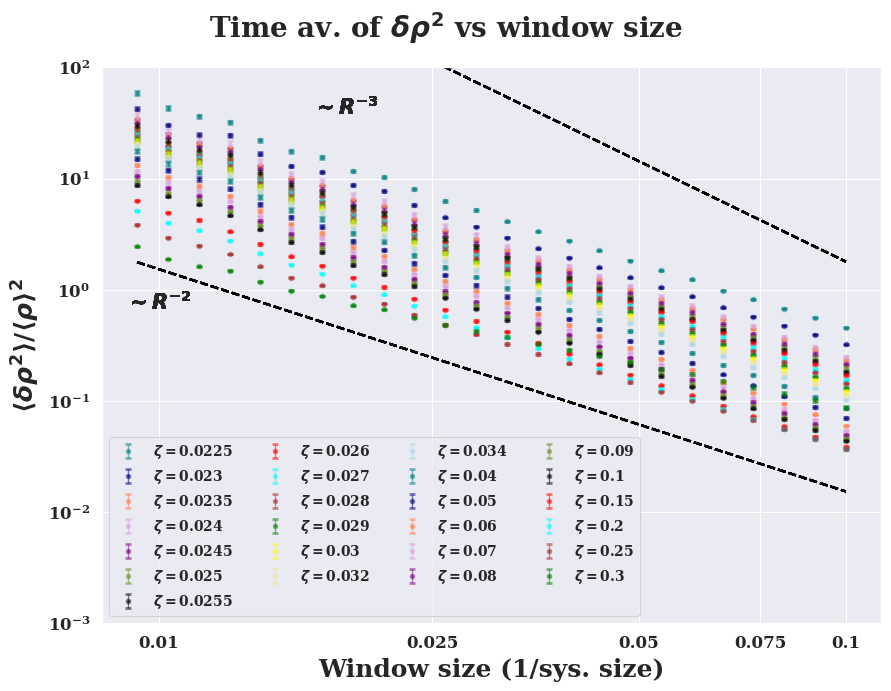

In [44]:

fig, ax = plt.subplots(figsize=(9,7))
for i, act in enumerate(act_list):
    if act < 0.0225:
        continue

    frames_av_dens = np.mean(dens_fluc_av[first_frame_list[i]:, min_window_idx:,i], axis = 0)
    frames_av_dens_std = np.mean(dens_fluc_std[first_frame_list[i]:, min_window_idx:,i], axis = 0) \
                      / np.sqrt(Nframes_non_nan_counts[i])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
        fit = do_chi2_fit(fit_func, np.log(R), np.log(frames_av_dens), frames_av_dens_std / frames_av_dens, param_guess, verbose = False)

    Ndof, chi2, prop = get_statistics_from_fit(fit, len(R), subtract_1dof_for_binning = False)

    fit_params_time_av[i, :Nparams] = fit.values[:]
    fit_params_time_av[i, Nparams:] = fit.errors[:]
    stat_arr_time_av[i, :] = Ndof, chi2, prop


    ax.errorbar(window_sizes[min_window_idx:], frames_av_dens, \
                frames_av_dens_std, fmt='.', label = fr'$\zeta = ${act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)

    ax.plot(window_sizes[min_window_idx:], 10 / window_sizes[min_window_idx:] ** (2), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.03, 0.6, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

    ax.plot(window_sizes[min_window_idx:], 30000/ window_sizes[min_window_idx:] ** (3), '--', color='black', alpha=0.5, lw = 1.5)
    ax.text(0.27, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_xlabel('Window size (1/sys. size)')
ax.set_ylabel(rf'$\langle \delta \rho ^2 \rangle /  \langle \rho \rangle ^2$')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=0.001, top = 100)
xticks = np.array([1, 2.5, 5, 7.5, 10]) * 2.56
ax.set_xticks(xticks, labels = np.round(xticks / 256,3))
ax.legend(ncol=4, fontsize = 10, loc = 'lower left') 

fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size')
fig.tight_layout()

print(fit_params_time_av[:,0])
print(stat_arr_time_av[:,-1])

np.save(os.path.join(save_path, f'fit_params_{save_suffix}_normalize{normalize}_time_av.npy'), fit_params_time_av)
np.save(os.path.join(save_path, f'stat_arr_{save_suffix}_normalize{normalize}_time_av.npy'), stat_arr_time_av)

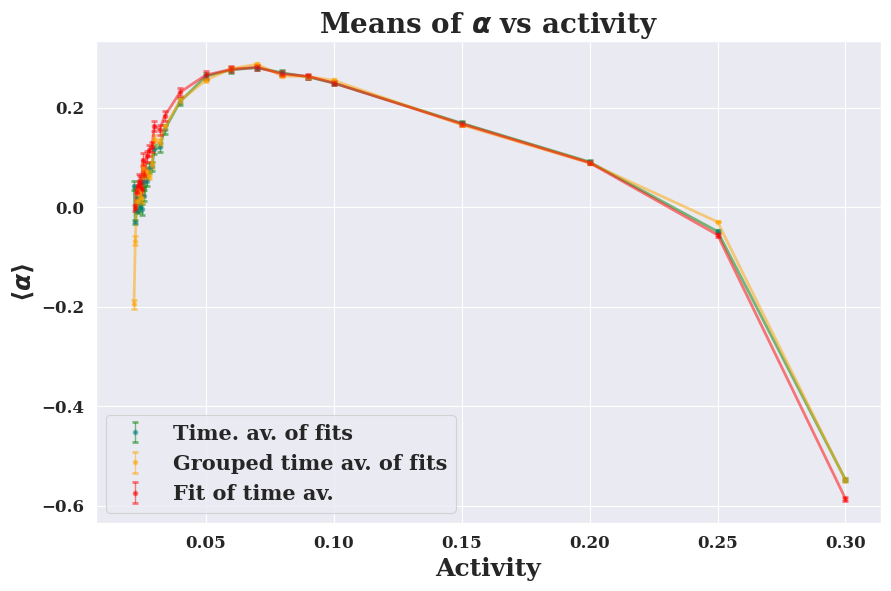

In [45]:
# calc weighted mean and error on mean for all frames and activities

Ngroup = 5
group = True
weighted_means_list = []
weighted_errs_list = []
weighted_means_group_list = []
weighted_errs_group_list = []

for i, act in enumerate(act_list):
        if act < act_list[min_act_idx]:
               continue
        
        if group:
                x = fit_params[first_frame_list[i]:, i, 0]

                max_idx = len(x) - len(x) % Ngroup
                # group the data and calculate the weighted mean and error on mean
                x_group = x[:max_idx].reshape(-1, Ngroup).mean(axis=1)
                dx_group = np.std(x[:max_idx].reshape(-1, Ngroup), axis=1, ddof=min(Ngroup-2, 1)) / np.sqrt(Ngroup)

                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x_group, dx_group)
                weighted_means_group_list.append(mean)
                weighted_errs_group_list.append(err)
      
        if 1:
             #   p_mask = (0.05 < stat_arr[first_frame_list[i]:, i, 2])  
                x = fit_params[first_frame_list[i]:, i, 0][p_mask]
                dx = fit_params[first_frame_list[i]:, i, Nparams][p_mask]

        try:
                mean, err, Ndof, chi2, p_val = calc_weighted_mean_vec(x, dx)
                weighted_means_list.append(mean)
                weighted_errs_list.append(err)
        except:
                print("No fits for activity = {}".format(act))
                weighted_means_list.append(np.nan)
                weighted_errs_list.append(np.nan)


fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.errorbar(act_list[min_act_idx:], weighted_means_list, weighted_errs_list, fmt='.', label = 'Time. av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='green')
ax2.plot(act_list[min_act_idx:], weighted_means_list, '-', color='green', alpha=0.5, )
ax2.errorbar(act_list[min_act_idx:], weighted_means_group_list, weighted_errs_group_list, fmt='.', label = 'Grouped time av. of fits', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='orange', color = 'orange')
ax2.plot(act_list[min_act_idx:],weighted_means_group_list,  '-',color='orange', alpha=0.5)
ax2.errorbar(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], fit_params_time_av[min_act_idx:,Nparams], fmt='.', label = 'Fit of time av.', \
             capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4, ecolor='red', color = 'red'
             )
ax2.plot(act_list[min_act_idx:], fit_params_time_av[min_act_idx:,0], '-', color='red', alpha=0.5)

ax2.set_xlabel('Activity')
ax2.set_ylabel(rf'$\langle\alpha \rangle$')
ax2.set_title(rf'Means of $\alpha $ vs activity')
ax2.legend()
fig2.tight_layout()

In [109]:
act_idx_very_long_lower

6

In [110]:
act_list[act_idx_very_long_lower:act_idx_very_long]

[0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225]

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14156\3955180347.py:7: RuntimeWarning: Mean of empty slice
  dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14156\3955180347.py:17: RuntimeWarning: Mean of empty slice
  xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2
C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14156\3955180347.py:55: RuntimeWarning: Mean of empty slice
  xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)


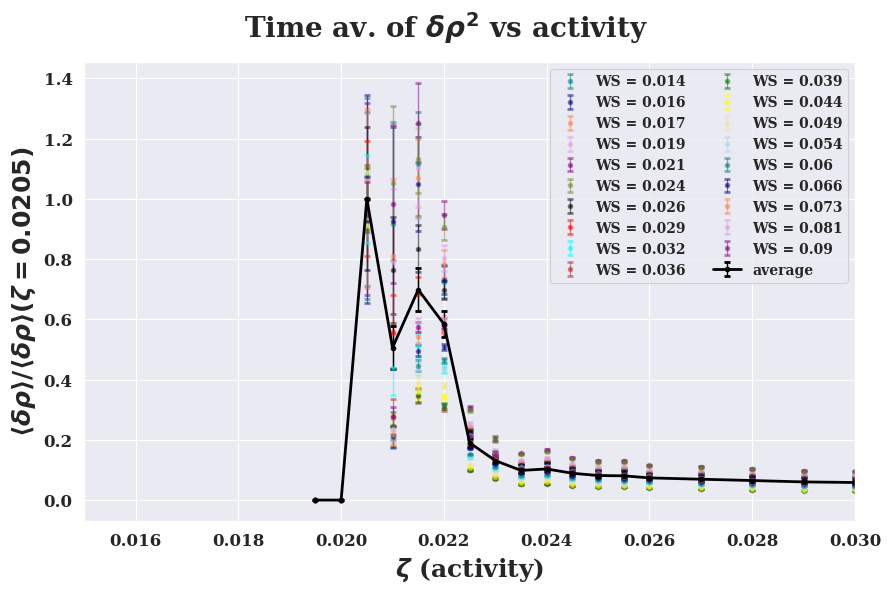

In [46]:
dens_fluc2 = np.load(os.path.join(save_path, 'dens_fluc.npy'))[:, :, :, idx_exp_to_keep_list][:, :, idx_act_to_keep_list, :]
dens_fluc2 = dens_fluc2 * exp_conv_list.T[np.newaxis, np.newaxis, :Nactivity, :]

av_dens_arr = defect_arr
dens_fluc2 = dens_fluc2 / av_dens_arr[:, None, :, :] ** 2

dens_fluc_av2 = np.nanmean(dens_fluc2, axis=3)
dens_fluc_std2 = np.nanstd(dens_fluc2, axis=3, ddof=1) / (np.sqrt(np.nanmean(exp_conv_list, axis=0))[:Nactivity])[None, None, :]

if 0:
    av_density_all_windows2 = av_defects_conv[:, 0] 
    dens_fluc_av2 = dens_fluc_av2 / av_density_all_windows2[:, None, :] ** 2
    dens_fluc_std2 = dens_fluc_std2 / av_density_all_windows2[:, None, :] ** 2

logplot = False

xi_av =  np.nanmean(dens_fluc_av2, axis = 0) #* window_sizes[:, None]**2  #** 2
xi_std = np.nanstd(dens_fluc_av2, axis = 0, ddof=1) / np.sqrt(Nframes_non_nan_counts[np.newaxis, :]) #* window_sizes[:, None]**2 #** 2

xi_av[:, act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'xi_av_full_very_long.txt'))[:, :]
xi_std[:, act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'xi_std_full_very_long.txt'))[:, :]
xi_av[:, act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'xi_av_full_long.txt'))[:, -2:]
xi_std[:, act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'xi_std_full_long.txt'))[:, -2:]

# save
np.save(os.path.join(save_path, 'xi_av_full.npy'), xi_av)
np.save(os.path.join(save_path, 'xi_std_full.npy'), xi_std)

fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 10

max_window_cutoff_idx = -1

act_max_idx = act_list.index(0.0205)


if 1:

  xi_av_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
  xi_std_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
  for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
        if window >= window_sizes[max_window_cutoff_idx]:
            continue
        norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
        if j % 1 == 0: #in [1,2,3,4,5,6,7]:
            ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                            xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                  capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
        xi_av_vals[j,:] = xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm
        xi_std_vals[j,:] = xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm

  # plot average xi
  xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)
  xi_av_vals_std = np.nanstd(xi_av_vals, axis = 0) / np.sqrt(xi_av_vals.shape[0])
  ax.errorbar(act_list[min_act_cutoff_idx:], xi_av_vals_mean, xi_av_vals_std, label='average', fmt='.-', \
                  capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')
  ax.set_xlabel(rf'$\zeta$ (activity)')
  ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list[act_max_idx]}) $')
  ax.set_xlim(0.015,0.03)

  if logplot:
    #  ax.set_yscale('log')
      ax.set_xscale('log')

  #add legend above the plot in 3 rows
  ax.legend(loc='upper right', ncol=2, fontsize = 10,)
  fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
  fig.tight_layout()
  plt.show()

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_14156\104648605.py:23: RuntimeWarning: Mean of empty slice
  xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)


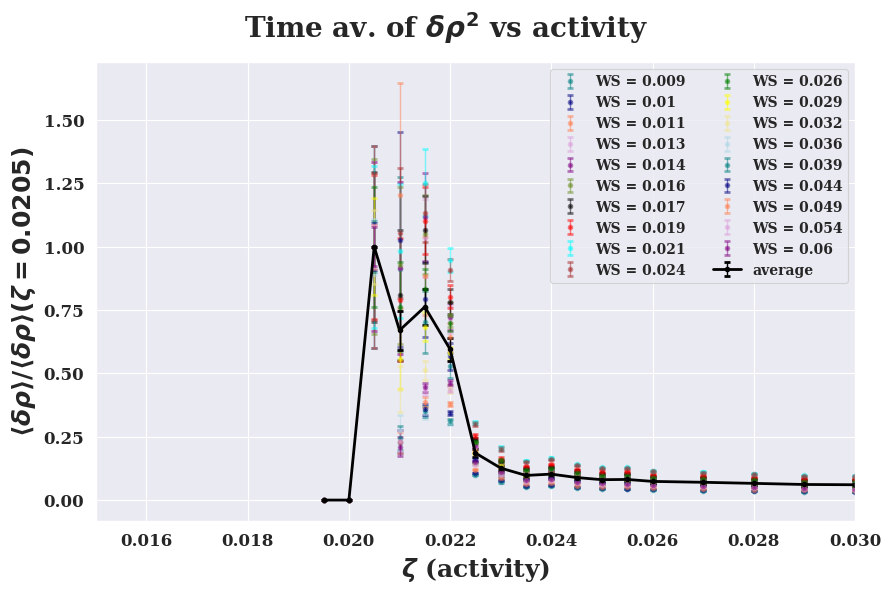

In [52]:

fig, ax = plt.subplots(figsize=(9,6))

min_act_cutoff_idx = 0
min_window_cutoff_idx = 6

max_window_cutoff_idx = 25

act_max_idx = act_list.index(0.0205)
xi_av_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
xi_std_vals = np.zeros( (len(window_sizes[min_window_cutoff_idx:max_window_cutoff_idx]), len(act_list[min_act_cutoff_idx:]) ))
for j, window in enumerate(window_sizes[min_window_cutoff_idx:]):
      if window >= window_sizes[max_window_cutoff_idx]:
          continue
      norm = xi_av[j + min_window_cutoff_idx, act_max_idx]
      if j % 1 == 0: #in [1,2,3,4,5,6,7]:
          ax.errorbar(act_list[min_act_cutoff_idx:], xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm,\
                          xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm, label=f'WS = {np.round(window / 256,3)}', fmt='.', \
                capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)
      xi_av_vals[j,:] = xi_av[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm
      xi_std_vals[j,:] = xi_std[j + min_window_cutoff_idx, min_act_cutoff_idx:] / norm

# plot average xi
xi_av_vals_mean = np.nanmean(xi_av_vals, axis = 0)
xi_av_vals_std = np.nanstd(xi_av_vals, axis = 0) / np.sqrt(xi_av_vals.shape[0])
ax.errorbar(act_list[min_act_cutoff_idx:], xi_av_vals_mean, xi_av_vals_std, label='average', fmt='.-', \
                capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color='black')
ax.set_xlabel(rf'$\zeta$ (activity)')
ax.set_ylabel(rf'$\langle \delta \rho \rangle / \langle \delta \rho \rangle (\zeta = {act_list[act_max_idx]}) $')
ax.set_xlim(0.015,0.03)

if logplot:
  #  ax.set_yscale('log')
    ax.set_xscale('log')

#add legend above the plot in 3 rows
ax.legend(loc='upper right', ncol=2, fontsize = 10,)
fig.suptitle(rf'Time av. of $\delta \rho ^2$ vs activity', fontsize=20)
fig.tight_layout()
plt.show()

In [54]:
act_list[act_idx_very_long_lower:act_idx_very_long]

[0.0195, 0.02, 0.0205, 0.021, 0.0215, 0.022, 0.0225, 0.023]

In [55]:
np.loadtxt(os.path.join(save_path, 'binder_tot_very_long.txt'))[:]

array([-1.65004, -0.71947, -0.68104,  0.11918, -0.61297, -0.79368,
       -0.00504,  0.39185,  0.59238,  0.6405 ,  0.65488])

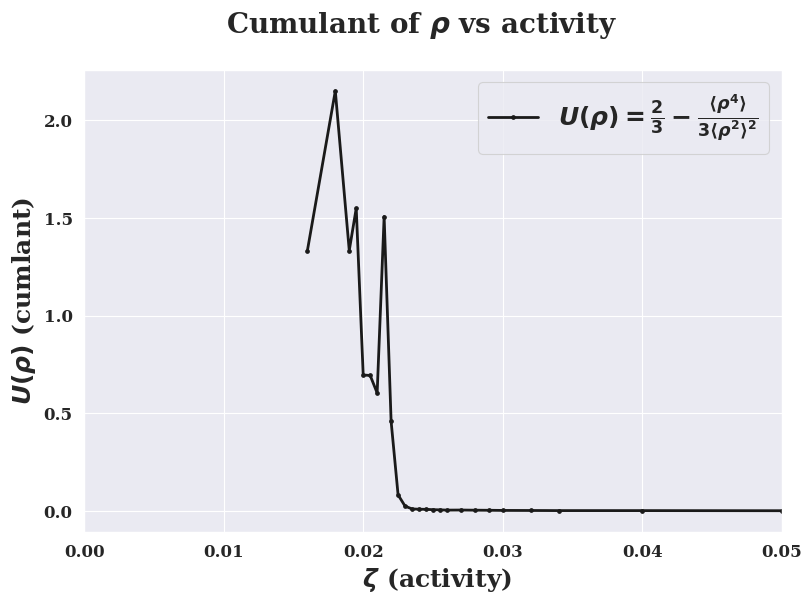

In [56]:
binder_tot = 1 - np.nanmean(np.nanmean(defect_arr[:,:,:] ** 4, axis = -1), axis = 0) \
  / (3 * np.nanmean(np.nanmean(defect_arr[:,:,:] ** 2, axis = -1), axis = 0) ** 2)


binder_tot[act_idx_very_long_lower:act_idx_very_long] = np.loadtxt(os.path.join(save_path, 'binder_tot_very_long.txt'))[:]
binder_tot[act_idx_long-2:act_idx_long] = np.loadtxt(os.path.join(save_path, 'binder_tot_long.txt'))[-2:]

# save
np.save(os.path.join(save_path, f'binder_tot.npy'), binder_tot)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(act_list, 2/3 - binder_tot, 'k.-', label=r'$U(\rho) = \frac{2}{3} - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$')

ax.set_xlim(0, 0.05)
ax.set_xlabel(r' $\zeta$ (activity)')
ax.set_ylabel(r'$U(\rho)$ (cumlant)')
ax.legend(loc='upper right', ncol=2, fontsize = 18)
fig.suptitle(rf'Cumulant of $\rho$ vs activity', fontsize=20)

plt.show()